# Allen's interval algebra

### Naive method based on the relation matrix

Import required packages

In [1]:
try:
  import pm4py
except:
  !pip install -U pm4py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Tuple
from matplotlib.patches import Rectangle
from pm4py import discover_bpmn_inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

In [2]:
log = xes_importer.apply("logs/exercise6.xes")
el_df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
el_df.head()

c:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
c:\Users\domin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 132/132 [00:00<00:00, 1912.14it/s]


,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


Clean the event log

In [3]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
  df["start_ts"] = df[df["lifecycle:transition"] == "start"]["time:timestamp"].map(lambda t: t.timestamp())
  df["complete_ts"] = df[df["lifecycle:transition"] == "complete"]["time:timestamp"].map(lambda t: t.timestamp())
  df.drop(["org:resource", "lifecycle:transition", "time:timestamp"], axis=1, inplace=True)
  df = df.rename(columns={"concept:name": "task_name", "case:concept:name": "case_id"})
  df = df[["case_id", "task_name", "start_ts", "complete_ts"]]
  df = df.groupby(["case_id", "task_name"], as_index=False).agg({"start_ts": "first", "complete_ts": "last"})
  df["interval_ts"] = df["complete_ts"] - df["start_ts"]
  df.sort_values(["case_id", "start_ts"], inplace=True, ignore_index=True)

  return df

el_df_cleaned = clean(el_df.copy())
el_df_cleaned.head()

,case_id,task_name,start_ts,complete_ts,interval_ts
0,0,check if sufficient information is available,1.136070e+09,1.137193e+09,1123200.0
1,0,register claim,1.137193e+09,1.201648e+09,64454400.0
2,0,determine likelihood of claim,1.201648e+09,1.205795e+09,4147200.0
3,0,assess claim,1.205795e+09,1.286924e+09,81129600.0
4,0,initiate payment,1.286924e+09,1.288566e+09,1641600.0


### Naive method based on relation matrix

Create empty relation matrix

In [4]:
task_names = el_df_cleaned["task_name"].unique()

relation_matrix = pd.DataFrame(np.full([len(task_names), len(task_names)], "-"), index=task_names, columns=task_names)
relation_matrix.head()

,check if sufficient information is available,register claim,determine likelihood of claim,assess claim,initiate payment,advise claimant on reimbursement,close claim,end
check if sufficient information is available,-,-,-,-,-,-,-,-
register claim,-,-,-,-,-,-,-,-
determine likelihood of claim,-,-,-,-,-,-,-,-
assess claim,-,-,-,-,-,-,-,-
initiate payment,-,-,-,-,-,-,-,-


###### Relationships implemented according to https://en.wikipedia.org/wiki/Allen%27s_interval_algebra

In [5]:
def find_allens_algebra_relation_between_tasks(left_task, right_task):
    if left_task["complete_ts"] < right_task["start_ts"]:
        return "<;>"
    elif left_task["complete_ts"] == right_task["start_ts"]:
        return "m;mi"
    else: 
        if left_task["start_ts"] == right_task["start_ts"]:
            if left_task["complete_ts"] == right_task["complete_ts"]:
                return "=;="
            else:
                return "si;si"
        else:
            if left_task["complete_ts"] < right_task["complete_ts"]:
                return "o;oi"
            elif left_task["complete_ts"] == right_task["complete_ts"]:
                return "fi;f"
            else:
                return "di;d"
            
def update_relation_matrix(left_task_name, right_task_name, relation, relation_matrix):
    relation, inverse_relation = relation.split(";")
    
    relation_matrix[left_task_name][right_task_name] = relation_matrix[left_task_name][right_task_name] + [relation] \
        if relation_matrix[left_task_name][right_task_name] != "-" else [relation]
    relation_matrix[right_task_name][left_task_name] = relation_matrix[right_task_name][left_task_name] + [inverse_relation] \
        if relation_matrix[right_task_name][left_task_name] != "-" else [inverse_relation]

In [6]:
# Number of following tasks considered in the context of finding relations
number_of_following_tasks_considered = 3

case_ids = el_df_cleaned["case_id"].unique()
for case_id in case_ids:
    el_df_cleaned_case_id = el_df_cleaned[el_df_cleaned["case_id"] == case_id].reset_index()

    for left_task_idx, left_task in el_df_cleaned_case_id.iterrows():
        for right_task_idx in range(left_task_idx + 1, min(left_task_idx + number_of_following_tasks_considered + 1, el_df_cleaned_case_id.shape[0])): # min used to avoid errors at the end of the DataFrame
            right_task = el_df_cleaned_case_id.iloc[right_task_idx] 
            
            relation = find_allens_algebra_relation_between_tasks(left_task, right_task)
            update_relation_matrix(left_task["task_name"], right_task["task_name"], relation, relation_matrix)

relation_matrix.head(8)

,check if sufficient information is available,register claim,determine likelihood of claim,assess claim,initiate payment,advise claimant on reimbursement,close claim,end
check if sufficient information is available,-,"[mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, m...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...",-,-,-,"[mi, mi, mi, mi, >, mi, mi, mi, >, mi, >, >, >..."
register claim,"[m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, ...",-,"[mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, m...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...",-,"[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ..."
determine likelihood of claim,"[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, ...",-,"[mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, m...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...","[>, >, >, >, >, >, >, >, >, >, >, >, >]","[mi, >, >, mi, >, >, mi, mi, mi, >, >, >, >, m..."
assess claim,"[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, ...",-,"[mi, >, mi, >, >, mi, >, >, mi, mi, mi, >, mi,...","[>, mi, >, mi, mi, >, mi, mi, >, >, >, mi, >, ...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ...","[mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, mi, m..."
initiate payment,-,"[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[m, <, m, <, <, m, <, <, m, m, m, <, m, <, <, ...",-,"[mi, m, mi, m, m, >, m, m, mi, mi, >, m, >, m,...","[>, mi, >, mi, mi, mi, mi, mi, >, >, mi, mi, m...","[>, >, >, >, >, >, >, >, >, >, >, >, >, >, >, ..."
advise claimant on reimbursement,-,"[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[<, m, <, m, m, <, m, m, <, <, <, m, <, m, m, ...","[m, mi, m, mi, mi, <, mi, mi, m, m, <, mi, <, ...",-,"[mi, >, mi, >, >, m, >, >, mi, mi, m, >, m, >,...","[>, >, >, >, >, mi, >, >, >, >, mi, >, mi, >, ..."
close claim,-,-,"[<, <, <, <, <, <, <, <, <, <, <, <, <]","[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[<, m, <, m, m, m, m, m, <, <, m, m, m, m, m, ...","[m, <, m, <, <, mi, <, <, m, m, mi, <, mi, <, ...",-,"[mi, mi, mi, mi, mi, >, mi, mi, mi, mi, >, mi,..."
end,"[m, m, m, m, <, m, m, m, <, m, <, <, <, m, m, ...","[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[m, <, <, m, <, <, m, m, m, <, <, <, <, m, <, ...","[m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, ...","[<, <, <, <, <, <, <, <, <, <, <, <, <, <, <, ...","[<, <, <, <, <, m, <, <, <, <, m, <, m, <, <, ...","[m, m, m, m, m, <, m, m, m, m, <, m, <, m, m, ...",-


Evaluation of relation matrix

In [7]:
relation_threshold = 0.6

relations_occurence_rates_df = pd.DataFrame(columns=['Task 1', 'Task 2', 'Relations occurence rates'])
founded_relations = pd.DataFrame(columns=['Task 1', 'Relation', 'Task 2'])

for left_task_name, left_task_row in relation_matrix.iterrows():
    for right_task_name, relations_for_pair_of_tasks in left_task_row.items():
        relations_occurence_rates = dict((relation, relations_for_pair_of_tasks.count(relation) / len(relations_for_pair_of_tasks)) \
                                         for relation in set(relations_for_pair_of_tasks) if relation != "-")
        relations_occurence_rates_df_row = pd.DataFrame({'Task 1': [left_task_name], 'Task 2': [right_task_name], 'Relations occurence rates': [relations_occurence_rates]})
        relations_occurence_rates_df = pd.concat([relations_occurence_rates_df, relations_occurence_rates_df_row], axis=0, ignore_index=True)
        
        relations_occurence_rates_filtered = [relation for (relation, occurence_rate) in relations_occurence_rates.items() \
                                              if occurence_rate >= relation_threshold and relation != "-"]
        
        for filtered_relation in relations_occurence_rates_filtered:
            founded_relation = pd.DataFrame({'Task 1': [left_task_name], 'Relation': [filtered_relation], 'Task 2': [right_task_name]})
            founded_relations = pd.concat([founded_relations, founded_relation], axis=0, ignore_index=True)
         

# export DataFrame to txt file
path = r'relations_occurence_rates.txt'
with open(path, 'w') as f:
    relations_occurence_rates_string = relations_occurence_rates_df.to_string(header=False, index=False)
    f.write(relations_occurence_rates_string)

relations_occurence_rates_df.head()

,Task 1,Task 2,Relations occurence rates
0,check if sufficient information is available,check if sufficient information is available,{}
1,check if sufficient information is available,register claim,{'mi': 1.0}
2,check if sufficient information is available,determine likelihood of claim,{'>': 1.0}
3,check if sufficient information is available,assess claim,{'>': 1.0}
4,check if sufficient information is available,initiate payment,{}


In [8]:
founded_relations.head(100)

,Task 1,Relation,Task 2
0,check if sufficient information is available,mi,register claim
1,check if sufficient information is available,>,determine likelihood of claim
2,check if sufficient information is available,>,assess claim
3,register claim,m,check if sufficient information is available
4,register claim,mi,determine likelihood of claim
5,register claim,>,assess claim
6,register claim,>,initiate payment
7,register claim,>,advise claimant on reimbursement
8,register claim,>,end
9,determine likelihood of claim,<,check if sufficient information is available


#### Class structure

In [9]:
import abc
import numpy as np
import pandas as pd

class AllenRelationsFinderNaiveMethod(abc.ABC):
    def __init__(self,
                 logs):
        self.logs = logs
        task_names = self.logs["task_name"].unique()
        self.relation_matrix = pd.DataFrame(np.full([len(task_names), len(task_names)], "-"), index=task_names, columns=task_names)

    @staticmethod
    def find_allens_algebra_relation_between_tasks(left_task, right_task):
        if left_task["complete_ts"] < right_task["start_ts"]:
            return "<;>"
        elif left_task["complete_ts"] == right_task["start_ts"]:
            return "m;mi"
        else: 
            if left_task["start_ts"] == right_task["start_ts"]:
                if left_task["complete_ts"] == right_task["complete_ts"]:
                    return "=;="
                else:
                    return "si;si"
            else:
                if left_task["complete_ts"] < right_task["complete_ts"]:
                    return "o;oi"
                elif left_task["complete_ts"] == right_task["complete_ts"]:
                    return "fi;f"
                else:
                    return "di;d"

    def create_relation_matrix(self, number_of_following_tasks_considered):
        case_ids = self.logs["case_id"].unique()
        for case_id in case_ids:
            logs_per_case_id = self.logs[self.logs["case_id"] == case_id].reset_index()

            for left_task_idx, left_task in logs_per_case_id.iterrows():
                for right_task_idx in range(left_task_idx + 1, min(left_task_idx + number_of_following_tasks_considered + 1, logs_per_case_id.shape[0])): # min used to avoid errors at the end of the DataFrame
                    right_task = logs_per_case_id.iloc[right_task_idx] 
                    
                    relation = self.find_allens_algebra_relation_between_tasks(left_task, right_task)
                    self._update_relation_matrix(left_task["task_name"], right_task["task_name"], relation)

        return self.relation_matrix

    def find_relations(self, relation_threshold):
        relations_occurence_rates_df = pd.DataFrame(columns=['Task 1', 'Task 2', 'Relations occurence rates'])
        founded_relations = pd.DataFrame(columns=['Task 1', 'Relation', 'Task 2'])

        for left_task_name, left_task_row in self.relation_matrix.iterrows():
            for right_task_name, relations_for_pair_of_tasks in left_task_row.items():
                relations_occurence_rates = dict((relation, relations_for_pair_of_tasks.count(relation) / len(relations_for_pair_of_tasks)) \
                                                for relation in set(relations_for_pair_of_tasks) if relation != "-")
                relations_occurence_rates_df_row = pd.DataFrame({'Task 1': [left_task_name], 'Task 2': [right_task_name], 'Relations occurence rates': [relations_occurence_rates]})
                relations_occurence_rates_df = pd.concat([relations_occurence_rates_df, relations_occurence_rates_df_row], axis=0, ignore_index=True)
                
                relations_occurence_rates_filtered = [relation for (relation, occurence_rate) in relations_occurence_rates.items() \
                                                    if occurence_rate >= relation_threshold and relation != "-"]
                
                for filtered_relation in relations_occurence_rates_filtered:
                    founded_relation = pd.DataFrame({'Task 1': [left_task_name], 'Relation': [filtered_relation], 'Task 2': [right_task_name]})
                    founded_relations = pd.concat([founded_relations, founded_relation], axis=0, ignore_index=True)
                

        # export DataFrame to txt file
        path = r'relations_occurence_rates.txt'
        with open(path, 'w') as f:
            relations_occurence_rates_string = relations_occurence_rates_df.to_string(header=False, index=False)
            f.write(relations_occurence_rates_string)

        return founded_relations

    def _update_relation_matrix(self, left_task_name, right_task_name, relation):
        relation, inverse_relation = relation.split(";")
        
        self.relation_matrix[left_task_name][right_task_name] = self.relation_matrix[left_task_name][right_task_name] + [relation] \
            if self.relation_matrix[left_task_name][right_task_name] != "-" else [relation]
        self.relation_matrix[right_task_name][left_task_name] = self.relation_matrix[right_task_name][left_task_name] + [inverse_relation] \
            if self.relation_matrix[right_task_name][left_task_name] != "-" else [inverse_relation]
        

class AllenRelationsFinderNaiveMethodWithLimitedRelations(abc.ABC):
    def __init__(self,
                 logs,
                 possible_relations):
        self.logs = logs

        if set(possible_relations) == set(['meets', 'before']):
            self.find_allens_algebra_relation_between_tasks = AllenRelationsFinderNaiveMethodWithLimitedRelations.meets_before
        elif set(possible_relations) == set(['meets', 'starts', 'overlaps']):
            self.find_allens_algebra_relation_between_tasks = AllenRelationsFinderNaiveMethodWithLimitedRelations.meets_starts_overlaps
        else:
            raise ValueError("Unsupported relations group")

        task_names = self.logs["task_name"].unique()
        self.relation_matrix = pd.DataFrame(np.full([len(task_names), len(task_names)], "-"), index=task_names, columns=task_names)

    @staticmethod
    def meets_before(left_task, right_task):
        if left_task["complete_ts"] < right_task["start_ts"]:
            return "<;>"
        else: 
            return "m;mi"
        
    @staticmethod
    def meets_starts_overlaps(left_task, right_task):
        if left_task["complete_ts"] == right_task["start_ts"]:
            return "m;mi"
        elif left_task["start_ts"] == right_task["start_ts"]:
            return "si;si"
        else:
            return "o;oi"

    def create_relation_matrix(self, number_of_following_tasks_considered):
        case_ids = self.logs["case_id"].unique()
        for case_id in case_ids:
            logs_per_case_id = self.logs[self.logs["case_id"] == case_id].reset_index()

            for left_task_idx, left_task in logs_per_case_id.iterrows():
                for right_task_idx in range(left_task_idx + 1, min(left_task_idx + number_of_following_tasks_considered + 1, logs_per_case_id.shape[0])): # min used to avoid errors at the end of the DataFrame
                    right_task = logs_per_case_id.iloc[right_task_idx] 
                    
                    relation = self.find_allens_algebra_relation_between_tasks(left_task, right_task)
                    self._update_relation_matrix(left_task["task_name"], right_task["task_name"], relation)

        return self.relation_matrix

    def find_relations(self, relation_threshold):
        relations_occurence_rates_df = pd.DataFrame(columns=['Task 1', 'Task 2', 'Relations occurence rates'])
        founded_relations = pd.DataFrame(columns=['Task 1', 'Relation', 'Task 2'])

        for left_task_name, left_task_row in self.relation_matrix.iterrows():
            for right_task_name, relations_for_pair_of_tasks in left_task_row.items():
                relations_occurence_rates = dict((relation, relations_for_pair_of_tasks.count(relation) / len(relations_for_pair_of_tasks)) \
                                                for relation in set(relations_for_pair_of_tasks) if relation != "-")
                relations_occurence_rates_df_row = pd.DataFrame({'Task 1': [left_task_name], 'Task 2': [right_task_name], 'Relations occurence rates': [relations_occurence_rates]})
                relations_occurence_rates_df = pd.concat([relations_occurence_rates_df, relations_occurence_rates_df_row], axis=0, ignore_index=True)
                
                relations_occurence_rates_filtered = [relation for (relation, occurence_rate) in relations_occurence_rates.items() \
                                                    if occurence_rate >= relation_threshold and relation != "-"]
                
                for filtered_relation in relations_occurence_rates_filtered:
                    founded_relation = pd.DataFrame({'Task 1': [left_task_name], 'Relation': [filtered_relation], 'Task 2': [right_task_name]})
                    founded_relations = pd.concat([founded_relations, founded_relation], axis=0, ignore_index=True)
                

        # export DataFrame to txt file
        path = r'relations_occurence_rates.txt'
        with open(path, 'w') as f:
            relations_occurence_rates_string = relations_occurence_rates_df.to_string(header=False, index=False)
            f.write(relations_occurence_rates_string)

        return founded_relations

    def _update_relation_matrix(self, left_task_name, right_task_name, relation):
        relation, inverse_relation = relation.split(";")
        
        self.relation_matrix[left_task_name][right_task_name] = self.relation_matrix[left_task_name][right_task_name] + [relation] \
            if self.relation_matrix[left_task_name][right_task_name] != "-" else [relation]
        self.relation_matrix[right_task_name][left_task_name] = self.relation_matrix[right_task_name][left_task_name] + [inverse_relation] \
            if self.relation_matrix[right_task_name][left_task_name] != "-" else [inverse_relation]


#### Result of naive method

In [10]:
allen_relations_finder_naive_method = AllenRelationsFinderNaiveMethod(logs=el_df_cleaned)

relation_matrix = allen_relations_finder_naive_method.create_relation_matrix(number_of_following_tasks_considered=3)
founded_relations = allen_relations_finder_naive_method.find_relations(relation_threshold=0.7)

founded_relations.head(100)

,Task 1,Relation,Task 2
0,check if sufficient information is available,mi,register claim
1,check if sufficient information is available,>,determine likelihood of claim
2,check if sufficient information is available,>,assess claim
3,register claim,m,check if sufficient information is available
4,register claim,mi,determine likelihood of claim
5,register claim,>,assess claim
6,register claim,>,initiate payment
7,register claim,>,advise claimant on reimbursement
8,register claim,>,end
9,determine likelihood of claim,<,check if sufficient information is available


#### Result of naive method with limited relations

In [11]:
allen_relations_finder_naive_method = AllenRelationsFinderNaiveMethodWithLimitedRelations(logs=el_df_cleaned, possible_relations=['meets', 'before'])

relation_matrix = allen_relations_finder_naive_method.create_relation_matrix(number_of_following_tasks_considered=3)
founded_relations = allen_relations_finder_naive_method.find_relations(relation_threshold=0.7)

founded_relations.head(100)

,Task 1,Relation,Task 2
0,check if sufficient information is available,mi,register claim
1,check if sufficient information is available,>,determine likelihood of claim
2,check if sufficient information is available,>,assess claim
3,register claim,m,check if sufficient information is available
4,register claim,mi,determine likelihood of claim
5,register claim,>,assess claim
6,register claim,>,initiate payment
7,register claim,>,advise claimant on reimbursement
8,register claim,>,end
9,determine likelihood of claim,<,check if sufficient information is available


Check relations of artificial generated logs

In [12]:
from logs_generator import generate_logs

def adjust_generated_logs(logs):
    logs["start_ts"] = logs["start_timestamp"].map(lambda t: t.timestamp())
    logs["complete_ts"] = logs["complete_timestamp"].map(lambda t: t.timestamp())
    logs.drop(["start_timestamp", "complete_timestamp"], axis=1, inplace=True)

    return logs

In [13]:
generated_logs = adjust_generated_logs(generate_logs('starts'))

allen_relations_finder_naive_method = AllenRelationsFinderNaiveMethod(logs=generated_logs)

relation_matrix = allen_relations_finder_naive_method.create_relation_matrix(number_of_following_tasks_considered=1)
founded_relations = allen_relations_finder_naive_method.find_relations(relation_threshold=0.7)

founded_relations.head(100)

Generate relation 'A' starts 'B' 


,Task 1,Relation,Task 2
0,A,si,B
1,B,si,A


#### Execution time of naive method

Generate relation 'A' before 'B' 
.................................................................

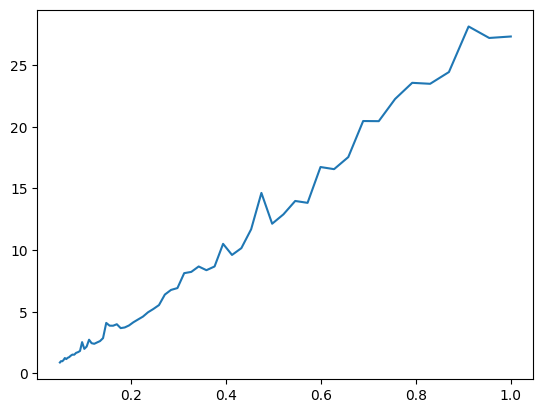

In [14]:
generated_logs = adjust_generated_logs(generate_logs('before'))

list_of_times = []
list_of_fraction = [x for x in np.logspace(-2, 0, 100) if x > 0.05]
for frac in list_of_fraction:
    rm = AllenRelationsFinderNaiveMethod(logs=generated_logs.sample(frac=frac, random_state=42))
    start_time = time.time()
    relation_matrix = rm.create_relation_matrix(number_of_following_tasks_considered=1)
    founded_relations = rm.find_relations(relation_threshold=0.7)
    execution_time = time.time() - start_time
    print(".", end="")
    list_of_times.append(execution_time)
plt.plot(list_of_fraction, list_of_times)
plt.show()


#### Execution time of naive method with limted relations

Generate relation 'A' before 'B' 
.................................................................

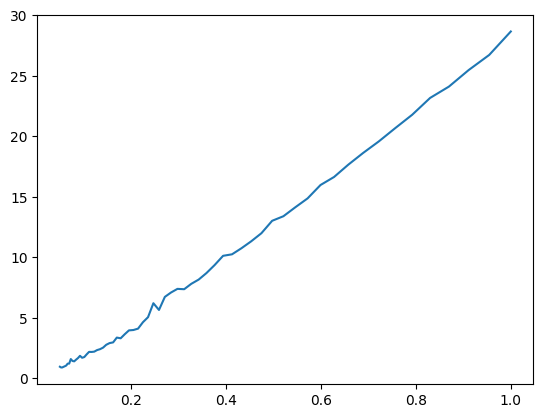

In [15]:
generated_logs = adjust_generated_logs(generate_logs('before'))

list_of_times = []
list_of_fraction = [x for x in np.logspace(-2, 0, 100) if x > 0.05]
for frac in list_of_fraction:
    rm = AllenRelationsFinderNaiveMethodWithLimitedRelations(logs=generated_logs.sample(frac=frac, random_state=42), possible_relations=['meets', 'before'])
    start_time = time.time()
    relation_matrix = rm.create_relation_matrix(number_of_following_tasks_considered=1)
    founded_relations = rm.find_relations(relation_threshold=0.7)
    execution_time = time.time() - start_time
    print(".", end="")
    list_of_times.append(execution_time)
plt.plot(list_of_fraction, list_of_times)
plt.show()